# Exoplanet Hunt

*This notebook contains the training of the final chosen model, its optimization and deployment.*

## Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import signal

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling1D, Input

from tensorflow.keras import models
from sklearn.metrics import confusion_matrix

from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='****************************', project_access_token='****************************')
pc = project.project_context



## Model & Features Choice

Based on the results of the experiments, conducted in ***`[ETL]models_training`***, 
it was decided that convolutional network (CNN) is the best fitted model for the current problem.

$$
\underline{\text{Final model: CNN}}
$$

As for the choice of the kind of training data engineering, it could have been seen that both ***detrended*** and ***frequency spectrum*** data have produced equally promicing results, however, the second has also shown the highest rate of detected stars with exoplanets.

Moreover, each its row is two times shorter due to the symmetry of frequency spectrum, which makes model training and prediction faster than that of the model based on only detrended data.

$$
\underline{\text{Features: normalized frequency spectrum of detrended signal}}
$$

## Evaluation

To evaluate model's performance one has defined a set of measures that would serve this purpose. 

However, some of them has proven useless, such as accuracy which value is $ \approx 0.99$ for almost every model, due to specifics of the data set and the precense of minoritary class. So, following shall be considered as pillars of model evaluation in this project:

1. ***`Loss - Binary CrossEntropy`***
2. ***`Sensitivity & Specificity`***
3. ***`Precision & Recall`***
4. ***`F1-score`***

Confusion matrices - a somewhat practical visualization of the model performance - will be considered as well.

In [3]:
def evaluate_prediction(y_true, y_pred, certainty=0.5, plot_cm=False):

    y_pred = y_pred.flatten('F')
    y_pred = np.array([1 if p >= certainty else 0 for p in y_pred])
    # calculating all the measures
    TP = len([p for i, p in enumerate(y_true) if y_pred[i] and p])
    TN = len([p for i, p in enumerate(y_pred) if not y_true[i] and not p])
    FP = len([p for i, p in enumerate(y_pred) if not y_true[i] and p])
    FN = len([p for i, p in enumerate(y_true) if not y_pred[i] and p])

    # evaluation
    Sensitivity = 0
    if (TP + FN):
        Sensitivity = TP/(TP + FN)

    Specificity = 0    
    if (TN + FP):
        Specificity = TN/(TN + FP)
    
    Precision = 0
    if (TP + FP):
        Precision = TP/(TP + FP)
        
    Recall = 0
    if (TN + FN):
        Recall = TN/(TN + FN)
    
    F1 = None
    if (Precision + Recall):
        F1 = 2*Precision*Recall/(Precision + Recall)

    score = pd.DataFrame([[Sensitivity, Specificity, Precision, Recall, F1]], 
                        columns=['Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-score'])
    
    if plot_cm:
        cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                        columns=['Predicted No planets', 'Predicted Planets'],
                        index=['True no planets', 'True Planets'])

        fig, ax = plt.subplots(figsize=(8, 8))
        hm = sns.heatmap(np.round(cm, 3), annot=True, ax=ax, 
                        cmap='magma', fmt='.3f')
        fig.suptitle('Confusion matrix', fontsize=18)
    
    return score

## Model definition

In [4]:
def CNN1D(input_shape, depth=8, dropout=0.25, nb_dense=512, activation='relu', summary=False):
    
    # input
    Input_Layer = Input(shape=input_shape, name='input')  

    # model
    # layer 1
    Y = Conv1D(depth, 3, padding='same', activation=activation)(Input_Layer)
    Y = MaxPooling1D()(Y)
    Y = Dropout(dropout)(Y)

    # layer 2
    Y = Conv1D(depth*2, 3, padding='same', activation=activation)(Y)
    Y = MaxPooling1D()(Y)
    Y = Dropout(dropout)(Y)

    # layer 3
    Y = Conv1D(depth*4, 3, padding='same', activation=activation)(Y)
    Y = MaxPooling1D()(Y)
    Y = Dropout(dropout)(Y)

    # output
    Y = Flatten()(Y)
    Y = Dense(nb_dense, activation='relu')(Y)
    Output_Layer = Dense(1, activation='sigmoid')(Y)

    model = tf.keras.Model(inputs=Input_Layer,
                        outputs = Output_Layer)
    
    # summarize layers
    if summary:
        print(model.summary())  

    return model

## Trainer

*A utility class, the aim of which is to train and evaluate Keras-made models.*

In [5]:
class Trainer():

    def __init__(self, model, model_name, train_data_generator, valid_data_generator):

        # data
        self.train_data = train_data_generator
        self.valid_data = valid_data_generator

        # model
        self.model = model
        self.best_model = model
        self.model_name = model_name + '.json'
        self.weights_name = model_name + '.h5'
        self.classes = 0

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history= []
        self.val_acc_history = []

        # early stopping
        self.best_epoch = 0
        self.patience = 0

        # evaluation info
        self.score = None

    def train(self, Nb_epochs,
              patience=10, monitor="val_loss", mode='min'):

        self.Nb_epochs = Nb_epochs
        self.patience = patience
        # early stopping initialization
        counter = 0
        self.best_epoch = 0
        if mode == 'min':
            best_value = 1e10
        if mode == 'max':
            best_value = -3      

            # training epoch
        try:
            for i in range(Nb_epochs):
                if counter >= patience:
                    print("The model is not improving any more. Stopping the training process..")
                    print("The last model was saved on epoch {:d}, with ".format(self.best_epoch) + 
                            monitor + " value of {:.2f}".format(best_value))
                    break
                starting_time = time.time()
                
                # data generation
                X_ep, Y_ep = next(self.train_data)
                X_val_ep, Y_val_ep = next(self.valid_data)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    initial_epoch=i,
                    epochs=i+1,    
                    validation_data=(X_val_ep, Y_val_ep))

                # saving training epoch history
                self.duration=time.time()-starting_time
                self.durations.append(self.duration)
                self.total_duration+=self.duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["acc"][0])
                self.val_acc_history.append(self.history.history["val_acc"][0])


                target = self.history.history[monitor][0]
                if mode == 'min':
                    if target < best_value:
                        print(monitor + " improved from {:.2f} to {:.2f}".format(best_value, target))
                        best_value = target
                        self.best_epoch = i+1
                        self.best_model = self.model
                        #self._save_model()
                        print("Model is saved on epoch {:d}.".format(self.best_epoch))
                        counter = 0
                    else:
                        print(monitor + " did not improve.")
                        counter += 1

                if mode == 'max':
                    if target > best_value:
                        print(monitor + " improved from {:.2f} to {:.2f}".format(best_value, target))
                        best_value = target
                        self.best_epoch = i+1
                        self.best_model = self.model
                        #self._save_model()
                        print("Model is saved on epoch {:d}.".format(self.best_epoch))
                        counter = 0
                    else:
                        print(monitor + " did not improve.")
                        counter += 1

            #self.load_model(model_name=self.model_name, weights_name=self.weights_name)
            self.model = self.best_model

        except KeyboardInterrupt:
            print("\n Interrupted.")
          
     
    def plot_training(self):

        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(min(self.Nb_epochs, self.best_epoch+self.patience))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)
        ax[0].tick_params(colors='coral')

        if len(a)<30:
            ax[0].set_xticks(a)
        else:
            ax[0].set_xticks(np.arange(0,self.Nb_epochs,50))
            ax[0].set_xticklabels(np.arange(0,self.Nb_epochs,50), rotation=75)

        ax[0].set_xlabel("epoch")
        fig.savefig("loss_per_epoch.png")

        # accuracy
        ax[1].plot(a,self.acc_history,label="acc")
        ax[1].plot(a,self.val_acc_history,label="val_acc")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        ax[1].tick_params(colors='coral')

        if len(a)<30:
            ax[1].set_xticks(a)
        else:
            ax[1].set_xticks(np.arange(0,self.Nb_epochs,50))
            ax[1].set_xticklabels(np.arange(0,self.Nb_epochs,50), rotation=75)

        ax[1].set_xlabel("epoch")
        fig.savefig("acc_per_epoch.png")
    
        return self.acc_history, self.val_acc_history, self.loss_history, self.val_loss_history
  
    def evaluate_model(self, test_data, y_true, certainty=0.5):

        loss, acc = self.model.evaluate(test_data)
        y_pred = self.model.predict(test_data)
        y_pred = y_pred.flatten('F')
        y_pred = np.array([1 if p >= certainty else 0 for p in y_pred])

        # Sensitivity
        TP = [p for i, p in enumerate(y_true) if y_pred[i] and p]

        if len(y_pred[y_pred == 1]):
            pos = len(y_pred[y_pred == 1])
            Sensitivity = len(TP)/pos
        else:
            Sensitivity = 0

        # Specificity
        TN = [p for i, p in enumerate(y_pred) if y_true[i] == 0 and not p]
        
        if len(y_pred[y_pred == 0]):
            neg = len(y_pred[y_pred == 0])
            Specificity = len(TN)/neg
        else:
            Specificity = 0

        score = pd.DataFrame([[loss, acc, Sensitivity, Specificity]], 
                            columns=['Loss', 'Accuracy', 'Sensitivity', 'Specificity'])
        
        cm = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='all'), 
                        columns=['Predicted No planets', 'Predicted Planets'],
                        index=['True no planets', 'True Planets'])

        fig, ax = plt.subplots(figsize=(8, 8))
        hm = sns.heatmap(np.round(cm, 3), annot=True, ax=ax, 
                        cmap='magma', fmt='.3f')
        fig.suptitle('Confusion matrix', fontsize=18)
        
        return score

    def _save_model(self):
      
        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)

    def load_model(self, replace=True, model_name="model.json", 
                 weights_name="model.h5"):
    
        # load json and create model
        json_file = open(model_name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = models.model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(weights_name)
        print("Model is loaded from a disk")
        
        if replace:
            self.model = loaded_model
        
        return loaded_model

## Data Access & Generation

In [6]:
def load_csv_Watson(filename):
    
    f = project.get_file(filename)
    x = pd.read_csv(f).to_numpy()
    return x

In [7]:
def train_generator(x_train, y_train, batch_size=100, ratio_of_minor=0.1):
    

    data = np.concatenate([x_train, y_train], axis=1)

    ones = data[data[:, -1] == 1]
    a_ones = np.arange(len(ones))
    zeros = data[data[:, -1] == 0]
    a_zeros = np.arange(len(zeros))

    # loop of the generator; 
    while True:    
        ones_to_pick = np.random.choice(a_ones, size=int(batch_size*ratio_of_minor))
        batch_of_ones = ones[ones_to_pick]
        zeros_to_pick = np.random.choice(a_zeros, size=int(batch_size*(1-ratio_of_minor)))
        batch_of_zeros = zeros[zeros_to_pick]

        batch = np.concatenate([batch_of_ones, batch_of_zeros], axis=0)
        

        yield batch[:, :-1, np.newaxis], batch[:, -1]

- The first of the above functions is the utility function that loads a csv file from IBM COS taking `filename`. 


- The second one is more interesting and even *crucial* for the successful training of the model. It is a customized `train_generator` that produces random batches of the given size and allows to boost minoritary class, making it appear `ratio_of_minor` times instead of possibly ***0*** while using usual random generator.

In [8]:
x_train = load_csv_Watson('x_train_freq.csv')
x_test = load_csv_Watson('x_test_freq.csv')

y_train = load_csv_Watson('labels_train.csv')
y_test = load_csv_Watson('labels_test.csv')

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
# custom train generators
BATCH_SIZE = 100
BATCH_SIZE_VAL = 50
BOOST = 0.2

train_gen = train_generator(x_train, y_train, ratio_of_minor=BOOST, batch_size=BATCH_SIZE)
val_gen = train_generator(x_train, y_train, ratio_of_minor=BOOST, batch_size=BATCH_SIZE_VAL)
a, b = next(train_gen)
a.shape, b.shape

((100, 1598, 1), (100,))

## Model Training

One has chosen the most promising model, however, now even more significant problem is up to be resolved: finding the most appropriate metaparameters of the model may significantly increase its performance and separate <u>*optimal*</u> model from *good* ones.

To find such parameters a grid search should be performed. During this procedure, all the given permatuations of parameter values will be tested. Although it is fairly simple as a concept, it is very computationally heavy with a complexity of $O(n^k)$ where $k$ is the number of parameters under evaluation. Thus, one should choose carefully, and, divide some comparisons if possible. That is why, it will be divided into two blocks:

- <u>***`Grid search over model metaparameters`***</u>
- <u>***`Grid search over training metaparameters`***</u>

It is also worth to consider the architecture of the network (e.g. number of layers), but in the given project the computational power at our disposal is limited, so we suppose, that it will already suffice to conduct the following experiments.

### Model's metaparameters grid search
In this subsection grid search is run over next parameters of the model:

* ***`Depths - number of filters in first convolutional layer;`***
* ***`Dropouts - dropout values;`***
* ***`Nbs_dense - number of neurons in the flattenning dense layer;`***
* ***`Activations - type of activation function.`***

In [12]:
model = CNN1D((x_train.shape[1], 1), depth=8, nb_dense=512, dropout=0.25, summary=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1598, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1598, 8)           32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 799, 8)            0         
_________________________________________________________________
dropout (Dropout)            (None, 799, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 799, 16)           400       
_________________________________________________________________
max_pooling1d_1 (MaxP

In [19]:
model = CNN1D((x_train.shape[1], 1), depth=8, nb_dense=512, dropout=0.25)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
trainer = Trainer(model, 'EXO_CNN', train_gen, val_gen)
trainer.train(5, patience=5)

Train on 100 samples, validate on 50 samples
100/100 [==============================] - 3s 33ms/sample - loss: 0.5256 - acc: 0.7700 - val_loss: 0.4493 - val_acc: 0.8000
val_loss improved from 10000000000.00 to 0.45
Model is saved on epoch 1.
Train on 100 samples, validate on 50 samples
Epoch 2/2
100/100 [==============================] - 1s 11ms/sample - loss: 0.4476 - acc: 0.8000 - val_loss: 0.4660 - val_acc: 0.8000
val_loss did not improve.
Train on 100 samples, validate on 50 samples
Epoch 3/3
100/100 [==============================] - 1s 10ms/sample - loss: 0.4426 - acc: 0.8000 - val_loss: 0.4237 - val_acc: 0.8000
val_loss improved from 0.45 to 0.42
Model is saved on epoch 3.
Train on 100 samples, validate on 50 samples
Epoch 4/4
100/100 [==============================] - 1s 9ms/sample - loss: 0.4161 - acc: 0.8000 - val_loss: 0.4199 - val_acc: 0.8000
val_loss improved from 0.42 to 0.42
Model is saved on epoch 4.
Train on 100 samples, validate on 50 samples
Epoch 5/5
100/100 [======

In [13]:
SCORES = pd.DataFrame(columns=['Model #', 'Loss', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-score'])
PARAMETERS_DF = pd.DataFrame(columns=['Model #', 'Depth', 'Dropout', 'Neurons in Dense', 'Activation'])
depths = [4, 8, 16]
dropouts = [0.1, 0.25, 0.5]
nbs_dense = [64, 128, 512]
activations = ['relu', 'sigmoid', 'tanh', 'selu']

In [14]:
SCORES.head()

,Model #,Loss,Sensitivity,Specificity,Precision,Recall,F1-score


In [15]:
start_time = time.time()
nb_epochs = 33
counter = 0

try:   
    for depth in depths:
        for dropo in dropouts:
            for nb_dense in nbs_dense:
                for act in activations:
                    print("Starting training of model #{:d}.".format(counter))

                    # saving training information
                    params = pd.DataFrame([[counter, depth, dropo, nb_dense, act]],
                                          columns=['Model #', 'Depth', 'Dropout', 'Neurons in Dense', 'Activation'])
                    PARAMETERS_DF = PARAMETERS_DF.append([params], sort=False)

                    # creation & training
                    model = CNN1D((x_train.shape[1], 1), depth=depth, nb_dense=nb_dense, dropout=dropo, activation=act)
                    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                              loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
                    trainer = Trainer(model, 'EXO_CNN', train_gen, val_gen)
                    trainer.train(nb_epochs, patience=nb_epochs)

                    # evaluation
                    model = trainer.best_model
                    y_pred = model.predict(x_test[:, :, np.newaxis])
                    loss, acc = model.evaluate(x_test[:, :, np.newaxis], y_test)
                    score = evaluate_prediction(y_test, y_pred)
                    score['Loss'] = loss
                    score['Model #'] = counter

                    # saving results
                    SCORES = pd.concat([SCORES, score], sort=False, ignore_index=False)

                    counter += 1
                    print(".----------------------------------------------------------------------------------------------.")
                    print("\n")
except Exception:
    print('Grid search interrupted.')

total_time = time.time() - start_time
print('Grid search over model metaparameters took {:.2f} seconds, or {:.2f} minutes.'.format(total_time, total_time/60))

Starting training of model #0.
Instructions for updating:
Use tf.cast instead.
Train on 100 samples, validate on 50 samples
Instructions for updating:
Use tf.cast instead.
100/100 [==============================] - 3s 33ms/sample - loss: 0.6084 - acc: 0.8100 - val_loss: 0.5090 - val_acc: 0.8000
val_loss improved from 10000000000.00 to 0.51
Model is saved on epoch 1.
Train on 100 samples, validate on 50 samples
Epoch 2/2
100/100 [==============================] - 1s 10ms/sample - loss: 0.4861 - acc: 0.8000 - val_loss: 0.4818 - val_acc: 0.8000
val_loss improved from 0.51 to 0.48
Model is saved on epoch 2.
Train on 100 samples, validate on 50 samples
Epoch 3/3
100/100 [==============================] - 1s 11ms/sample - loss: 0.4532 - acc: 0.8000 - val_loss: 0.4561 - val_acc: 0.8000
val_loss improved from 0.48 to 0.46
Model is saved on epoch 3.
Train on 100 samples, validate on 50 samples
Epoch 4/4
100/100 [==============================] - 1s 10ms/sample - loss: 0.4504 - acc: 0.8000 - val

In [17]:
PARAMETERS_DF.head()

,Model #,Depth,Dropout,Neurons in Dense,Activation
0,0,4,0.1,64,relu
0,1,4,0.1,64,sigmoid
0,2,4,0.1,64,tanh
0,3,4,0.1,64,selu
0,4,4,0.1,128,relu


In [18]:
SCORES.head()

,Model #,Loss,Sensitivity,Specificity,Precision,Recall,F1-score
0,0,0.136723,0.4,0.998230,0.666667,0.994709,0.798301
0,1,0.198384,0.0,1.000000,0.000000,0.991228,0.000000
0,2,0.108873,0.8,0.991150,0.444444,0.998217,0.615047
0,3,0.040752,0.2,0.989381,0.142857,0.992895,0.249777
0,4,0.058069,0.8,0.998230,0.800000,0.998230,0.888189


In [19]:
# saving results dataframes obtained with grid search 
project.save_data("model_parameters_df.csv", PARAMETERS_DF.to_csv(index=False, header=True), overwrite=True)
project.save_data("model_scores_df.csv", SCORES.to_csv(index=False, header=True), overwrite=True)

{'file_name': 'model_scores_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-ld3odwtjkc2q9w',
 'asset_id': 'd6fcacc0-5761-4463-ba0e-a1816c72e560'}

### Load & examine results

In [29]:
# loading grid search results from COS
f_p = project.get_file("model_parameters_df.csv")
PARAMETERS_DF = pd.read_csv(f_p)

f_s = project.get_file("model_scores_df.csv")
SCORES = pd.read_csv(f_s)

In [30]:
top8 = list(SCORES.nlargest(8, 'F1-score')['Model #'])
SCORES.nlargest(8, 'F1-score')

,Model #,Loss,Sensitivity,Specificity,Precision,Recall,F1-score
83,83,0.013604,0.2,1.00000,1.000000,0.992970,0.996473
4,4,0.058069,0.8,0.99823,0.800000,0.998230,0.888189
16,16,0.189381,0.8,0.99646,0.666667,0.998227,0.799432
79,79,0.020663,0.8,0.99646,0.666667,0.998227,0.799432
82,82,0.013120,0.8,0.99646,0.666667,0.998227,0.799432
0,0,0.136723,0.4,0.99823,0.666667,0.994709,0.798301
47,47,0.018244,0.4,0.99823,0.666667,0.994709,0.798301
95,95,0.020598,0.4,0.99823,0.666667,0.994709,0.798301


In [31]:
PARAMETERS_DF.iloc[top8]

,Model #,Depth,Dropout,Neurons in Dense,Activation
83,83,16,0.10,512,selu
4,4,4,0.10,128,relu
16,16,4,0.25,128,relu
79,79,16,0.10,128,selu
82,82,16,0.10,512,tanh
0,0,4,0.10,64,relu
47,47,8,0.10,512,selu
95,95,16,0.25,512,selu


***Comment:*** <u>***`Model #4 is the chosen one.`***</u> 

It presents a nice balance between sensitivity and precision, which is what one desires to have to successfully identify the stars with exoplanets in their orbits.

In [32]:
chosen_model_parameters = PARAMETERS_DF.iloc[4]
chosen_model_parameters

Model #                4
Depth                  4
Dropout              0.1
Neurons in Dense     128
Activation          relu
Name: 4, dtype: object

### Training metaparameters grid search

After best model configuration is found, one aims to find the best approach to training process of the model.

Grid search will be conducted over:

* ***`Batches - batch size;`***
* ***`lrs - learning rate values;`***
* ***`Boosts - ratio of stars with exoplanets data in a batch;`***

In [11]:
TRAINING_SCORES = pd.DataFrame(columns=['Model #', 'Loss', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-score'])
TRAINING_PARAMETERS = pd.DataFrame(columns=['Model #', 'Batch size', 'Learning rate', 'Minoritary class boost'])
Batches = [20, 50, 100, 200]
lrs = [0.01, 0.001, 0.005, 0.0001]
Boosts = [0.05, 0.1, 0.2, 0.3]

In [12]:
start_time = time.time()
nb_epochs = 20
counter = 0

# model #4 setup
depth = 4
nb_dense = 128
act = 'relu'
dropo = 0.1

try:
    for batch_size in Batches:
        for lr in lrs:
            for boost in Boosts:
                print("Starting training of model #{:d}.".format(counter))

                # saving training information
                params = pd.DataFrame([[counter, batch_size, lr, boost]],
                                      columns=['Model #', 'Batch size', 'Learning rate', 'Minoritary class boost'])
                TRAINING_PARAMETERS = TRAINING_PARAMETERS.append([params], sort=False)

                # data generators
                train_gen = train_generator(x_train, y_train, ratio_of_minor=boost, batch_size=batch_size)
                val_gen = train_generator(x_train, y_train, ratio_of_minor=boost, batch_size=(batch_size//2))

                # creation & training
                model = CNN1D((x_train.shape[1], 1), depth=depth, nb_dense=nb_dense, dropout=dropo, activation=act)
                model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
                trainer = Trainer(model, 'EXO_CNN', train_gen, val_gen)
                trainer.train(nb_epochs, patience=nb_epochs)

                # evaluation
                model = trainer.best_model
                y_pred = model.predict(x_test[:, :, np.newaxis])
                loss, acc = model.evaluate(x_test[:, :, np.newaxis], y_test)
                score = evaluate_prediction(y_test, y_pred)
                score['Loss'] = loss
                score['Model #'] = counter

                # saving results
                TRAINING_SCORES = pd.concat([TRAINING_SCORES, score], sort=False, ignore_index=False)

                counter += 1
                print(".----------------------------------------------------------------------------------------------.")
                print("\n")
except Exception:
    print('Grid search interrupted.')

total_time = time.time() - start_time
print('Grid search over training metaparameters took {:.2f} seconds, or {:.2f} minutes.'.format(total_time, total_time/60))

Starting training of model #0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 20 samples, validate on 9 samples
Instructions for updating:
Use tf.cast instead.
20/20 [==============================] - 4s 202ms/sample - loss: 0.6890 - acc: 0.7000 - val_loss: 0.0127 - val_acc: 1.0000
val_loss improved from 10000000000.00 to 0.01
Model is saved on epoch 1.
Train on 20 samples, validate on 9 samples
Epoch 2/2
20/20 [==============================] - 5s 232ms/sample - loss: 0.3558 - acc: 0.9500 - val_loss: 0.0129 - val_acc: 1.0000
val_loss did not improve.
Train on 20 samples, validate on 9 samples
Epoch 3/3
20/20 [==============================] - 0s 14ms/sample - loss: 0.2508 - acc: 0.9500 - val_loss: 0.2785 - val_acc: 1.0000
val_loss did not improve.
Train on 20 samples, validate on 9 samples
E

In [13]:
TRAINING_SCORES.head()

,Model #,Loss,Sensitivity,Specificity,Precision,Recall,F1-score
0,0,0.059786,0.0,1.000000,0,0.991228,0.000000
0,1,0.148120,0.0,1.000000,0,0.991228,0.000000
0,2,0.175939,0.0,1.000000,0,0.991228,0.000000
0,3,0.181703,0.6,0.964602,0.130435,0.996344,0.230672
0,4,0.063947,0.0,1.000000,0,0.991228,0.000000


In [14]:
TRAINING_PARAMETERS.head()

,Model #,Batch size,Learning rate,Minoritary class boost
0,0,20,0.010,0.05
0,1,20,0.010,0.10
0,2,20,0.010,0.20
0,3,20,0.010,0.30
0,4,20,0.001,0.05


In [15]:
# saving results dataframes obtained with grid search 
project.save_data("training_parameters_df.csv", TRAINING_PARAMETERS.to_csv(index=False, header=True), overwrite=True)
project.save_data("training_scores_df.csv", TRAINING_SCORES.to_csv(index=False, header=True), overwrite=True)

{'file_name': 'training_scores_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-ld3odwtjkc2q9w',
 'asset_id': 'd6306533-110e-440a-98bf-ce16f08ffdf9'}

### Load & examine results

In [16]:
# loading grid search results from COS
f_p = project.get_file("training_parameters_df.csv")
TRAIN_PARAMETERS_DF = pd.read_csv(f_p)

f_s = project.get_file("training_scores_df.csv")
TRAIN_SCORES = pd.read_csv(f_s)

In [22]:
top8 = list(TRAIN_SCORES.nlargest(8, 'F1-score')['Model #'])
TRAIN_SCORES.nlargest(8, 'F1-score')

,Model #,Loss,Sensitivity,Specificity,Precision,Recall,F1-score
48,48,0.015855,0.6,0.998230,0.750000,0.996466,0.855842
33,33,0.015714,0.8,0.996460,0.666667,0.998227,0.799432
53,53,0.064459,0.4,0.998230,0.666667,0.994709,0.798301
56,56,0.017092,0.6,0.996460,0.600000,0.996460,0.749002
49,49,0.015120,0.8,0.994690,0.571429,0.998224,0.726802
54,54,0.070256,1.0,0.991150,0.500000,1.000000,0.666667
27,27,0.044144,1.0,0.989381,0.454545,1.000000,0.625000
50,50,0.019132,0.8,0.991150,0.444444,0.998217,0.615047


In [23]:
TRAIN_PARAMETERS_DF.iloc[top8]

,Model #,Batch size,Learning rate,Minoritary class boost
48,48,200,0.010,0.05
33,33,100,0.010,0.10
53,53,200,0.001,0.10
56,56,200,0.005,0.05
49,49,200,0.010,0.10
54,54,200,0.001,0.20
27,27,50,0.005,0.30
50,50,200,0.010,0.20


***Comment:***

In [24]:
chosen_training_parameters = TRAIN_PARAMETERS_DF.iloc[48]
chosen_training_parameters

Model #                    48.00
Batch size                200.00
Learning rate               0.01
Minoritary class boost      0.05
Name: 48, dtype: float64

### Final model training 

In [162]:
# data generators
train_gen = train_generator(x_train, y_train, ratio_of_minor=0.07, batch_size=200)
val_gen = train_generator(x_train, y_train, ratio_of_minor=0.08, batch_size=(100))
a, b = next(train_gen)
a.shape, b.shape

((200, 1598, 1), (200,))

In [163]:
chosen_model_parameters

Model #                4
Depth                  4
Dropout              0.1
Neurons in Dense     128
Activation          relu
Name: 4, dtype: object

In [164]:
model = CNN1D((x_train.shape[1], 1), depth=4, 
              nb_dense=128, dropout=0.1, activation='relu', summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1598, 1)           0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 1598, 4)           16        
_________________________________________________________________
max_pooling1d_273 (MaxPoolin (None, 799, 4)            0         
_________________________________________________________________
dropout_273 (Dropout)        (None, 799, 4)            0         
_________________________________________________________________
conv1d_274 (Conv1D)          (None, 799, 8)            104       
_________________________________________________________________
max_pooling1d_274 (MaxPoolin (None, 399, 8)            0         
_________________________________________________________________
dropout_274 (Dropout)        (None, 399, 8)            0         
__________

In [165]:
lr = 0.005
nb_epochs = 40

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
trainer = Trainer(model, 'EXO_CNN', train_gen, val_gen)
trainer.train(nb_epochs, patience=10)

Train on 200 samples, validate on 100 samples
200/200 [==============================] - 18s 91ms/sample - loss: 0.4704 - acc: 0.9150 - val_loss: 0.2669 - val_acc: 0.9200
val_loss improved from 10000000000.00 to 0.27
Model is saved on epoch 1.
Train on 200 samples, validate on 100 samples
Epoch 2/2
200/200 [==============================] - 6s 30ms/sample - loss: 0.2539 - acc: 0.9300 - val_loss: 0.2763 - val_acc: 0.9200
val_loss did not improve.
Train on 200 samples, validate on 100 samples
Epoch 3/3
200/200 [==============================] - 5s 25ms/sample - loss: 0.2384 - acc: 0.9300 - val_loss: 0.2726 - val_acc: 0.9200
val_loss did not improve.
Train on 200 samples, validate on 100 samples
Epoch 4/4
200/200 [==============================] - 5s 23ms/sample - loss: 0.2474 - acc: 0.9300 - val_loss: 0.2535 - val_acc: 0.9200
val_loss improved from 0.27 to 0.25
Model is saved on epoch 4.
Train on 200 samples, validate on 100 samples
Epoch 5/5
200/200 [==============================] - 2s

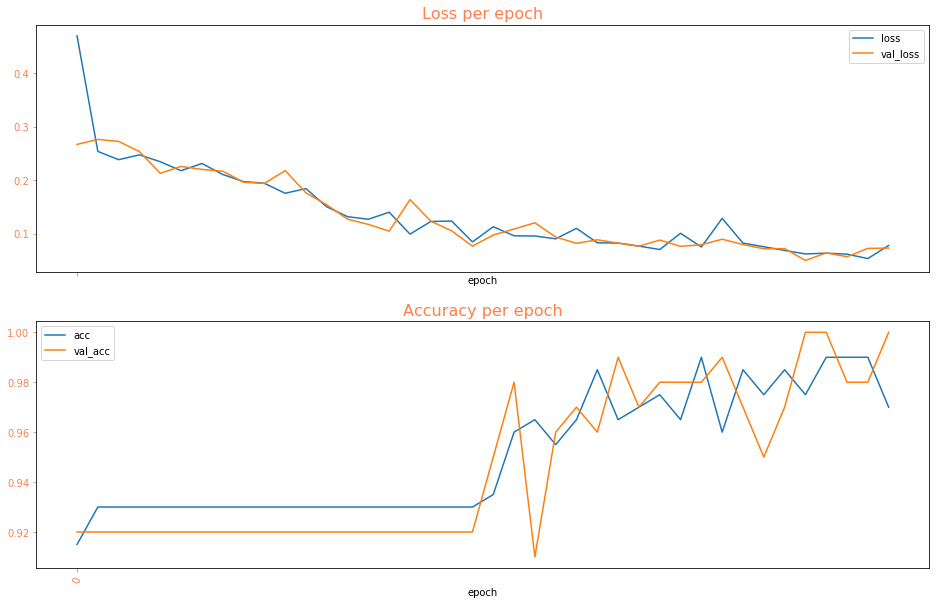

In [166]:
trainer.plot_training();

570/570 [==============================] - 2s 3ms/sample - loss: 0.0213 - acc: 0.9965


,Sensitivity,Specificity,Precision,Recall,F1-score,Loss,Accuracy
0,0.8,0.99823,0.8,0.99823,0.888189,0.02133,0.996491


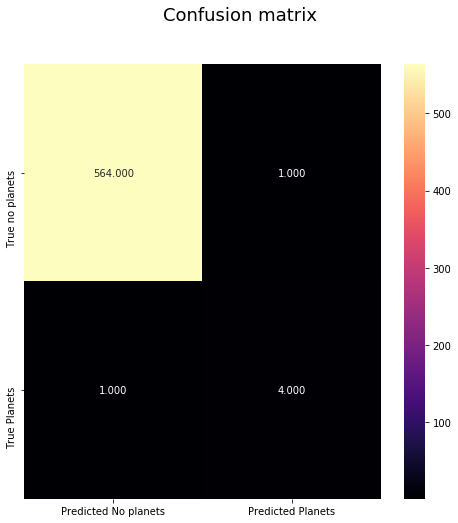

In [167]:
model = trainer.best_model
y_pred = model.predict(x_test[:, :, np.newaxis])
loss, acc = model.evaluate(x_test[:, :, np.newaxis], y_test)
score = evaluate_prediction(y_test, y_pred, plot_cm=True, certainty=0.5)
score['Loss'] = loss
score['Accuracy'] = acc
score.head()

## Model deployment

*Now it's time to save the final model and deploy it.*

*To do that one will use Watson Machine Learning service.*

In [175]:
model.save("final_exo_cnn.h5")

In [176]:
!ls -lah

total 4.9M
drwxr-x--- 2 dsxuser dsxuser 4.0K Jun  3 00:40 .
drwx------ 1 dsxuser dsxuser 4.0K Jun  2 18:48 ..
-rw-r----- 1 dsxuser dsxuser  53K Jun  3 00:37 acc_per_epoch.png
-rw-r----- 1 dsxuser dsxuser 4.8M Jun  3 00:40 final_exo_cnn.h5
-rw-r----- 1 dsxuser dsxuser  31K Jun  3 00:37 loss_per_epoch.png


In [177]:
!tar -zcvf final_model.tgz final_exo_cnn.h5

final_exo_cnn.h5


### Saving final trained model to WML Repository

In [178]:
wml_credentials={
  "apikey": "**************************",
  "iam_apikey_description": "**************************",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "**************************",
  "iam_serviceid_crn": "************************",
  "instance_id": "*****************************",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [179]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [180]:
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "*****************", 
               client.repository.ModelMetaNames.AUTHOR_EMAIL: "****************", 
               client.repository.ModelMetaNames.NAME: "Exo_CNN",
               client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
               client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.15" ,
               client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name": "keras", "version": "2.2.5"}]
              }

In [181]:
published_model = client.repository.store_model(model="final_model.tgz", meta_props=model_props)

In [182]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

### Model Deployment

In [183]:
client.deployments.list()

------------------------------------  -------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                 TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
35a28d5e-5347-4853-96bb-ee461d46a061  k1_keras_mnist_clt1  online  DEPLOY_SUCCESS  2020-05-09T19:47:21.164Z  tensorflow-1.15  model
------------------------------------  -------------------  ------  --------------  ------------------------  ---------------  -------------


In [184]:
new_deployment = client.deployments.create(published_model_uid, name="Exoplanet_Hunt")



#######################################################################################

Synchronous deployment creation for uid: '0a88724a-db13-4f0e-a23e-ba4afe94ff74' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='81037914-9db4-4233-8d51-fa3c48c0446d'
------------------------------------------------------------------------------------------------




### Testing Deployment

In [185]:
#scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
scoring_endpoint = new_deployment['entity']['scoring_url']
print(scoring_endpoint)

https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1c12715c-5a60-4f6c-a272-a4cff3259907/deployments/81037914-9db4-4233-8d51-fa3c48c0446d/online


In [2]:
y_test

In [206]:
one_star = 42
x_score_1 = x_test[:, :, np.newaxis][one_star].tolist()
scoring_payload = {'values': [x_score_1]}
predictions = client.deployments.score(scoring_endpoint, scoring_payload)
print('Star #', one_star)
if predictions['values'][0][0] < 0.5:
    print('This star has no exoplanets in its orbit.')
else:
    print('This star is likely to have exoplanets in its orbit.')
    
print("True label: ", y_test[one_star])

Star # 42
This star has no exoplanets in its orbit.
True label:  [0]


In [204]:
predictions

{'fields': ['prediction'], 'values': [[0.24566353857517242]]}

In [207]:
other_star = 3
x_score_1 = x_test[:, :, np.newaxis][other_star].tolist()
scoring_payload = {'values': [x_score_1]}
predictions = client.deployments.score(scoring_endpoint, scoring_payload)

print('Star #', other_star)
if predictions['values'][0][0] < 0.5:
    print('This star has no exoplanets in its orbit.')
else:
    print('This star is likely to have exoplanets in its orbit.')
    
print("True label: ", y_test[other_star])

Star # 3
This star is likely to have exoplanets in its orbit.
True label:  [1]


`The end.`